## Observed Weather Data Comparisons

### Objective

* Quantitative comparison between observed weather at disc golf courses and observed weather at nearby stations

### Rationale

* Why This?  Player performance is likely to be affected by actual weather at disc golf courses, but, particularly with regard to winds, micro-climatic effects can cause the actual winds at a course to differ significantly from observed winds at local weather stations.  Because forecast data is built on observations from nearby stations, forecasts will not capture these effects.  The only way to account for them is to compare observed information from actual courses with contemporaneous measurements at nearby stations.

* Why Me?  I have both the meteorological background as well as the model-building responsibilities for this project.

* Why Now?  This issue needs at least a preliminary resolution prior to the onset of model selection, as it may affect which weather characteristics (especially wind) are considered, and how uncertainties are handled.

### Requirements

* Pandas 0.24.2
* Matplotlib 3.1.0
* Numpy 1.16.4
* Scikit-learn 0.21.2
* SciPy 1.2.1

### Input / Output

* The notebook is expected to be in the folder `models/notebooks/eda`

* Input files for actual courses are in `models/wx_record/wx_at_course` while those for nearby stations (after processing) are at `models/wx_record/wx_station_by_date`

* Actual weather data files should have filenames formatted as `{wx-type}_mmddyy_courseid_{id}.csv`, where {wx-type} is a word like 'wind', and 'mmddyy' is the observation date and {id} is the course_id (0 for Golden Gate, 1 for Chabot, 2 for Aquatic Park)

* A mapping between weather station names and which courses they relate to is found in `models/geo/nearby_wunder_pws.csv`

### Import / Set-Up

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import r2_score
import scipy.stats as st
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
pws_df = pd.read_csv('../../geo/nearby_wunder_pws.csv')
pws_df.head()

,station_id,latitude,longitude,course_id,comments
0,KCABERKE85,NaN,NaN,2,no wind gust prior to 2018 and no wind guest i...
1,KCAALBAN12,NaN,NaN,2,winds appear significantly different on 7/24/19
2,KCABERKE104,NaN,NaN,2,NaN
3,KCABERKE28,NaN,NaN,2,NaN
4,KCASANFR1443,37.777023,-122.48484,0,NaN


In [8]:
# Get all data from actual courses
actual_wx_files = [filename for filename in glob.glob('../../wx_record/wx_at_course/wind_*.csv')]
actual_wx_files    

['../../wx_record/wx_at_course\\wind_072419_courseid_2.csv']

In [10]:
# ID course to pull station data from
course_id = int(actual_wx_files[0].split('_courseid_')[1].split('.')[0])
course_id

2

In [38]:
# Get list of nearby weather stations for this course
station_list = pws_df.loc[pws_df['course_id'] == course_id].station_id.values
station_list

array(['KCABERKE85', 'KCAALBAN12', 'KCABERKE104', 'KCABERKE28'],
      dtype=object)

In [80]:
# Get date
wx_date = actual_wx_files[0].split('_courseid_')[0][-6:]
# Note that the date formats are consistent for weather files as mmddyy, so we can use the date string directly
# Find weather records by date and course id, create list of dataframes
wx_data_list = []
stations = []
for station_name in station_list:
    wx_filename = '../../wx_record/wx_station_by_date/' + station_name + '_' + wx_date + '_p01.csv'
    try:
        wx_df = pd.read_csv(wx_filename, parse_dates = ['time'])
        # Clean as we go...
        wx_df = wx_df.drop(columns = ['Unnamed: 0'])
        wx_df = wx_df.set_index('time')
        wx_df = wx_df.dropna()
        wx_df = wx_df.sort_index()
        wx_data_list.append(wx_df)
        stations.append(station_name)
    except ValueError:
        pass
print(len(wx_data_list), end=' ')
print('matching station records found:')
print(stations)

4 matching station records found:
['KCABERKE85', 'KCAALBAN12', 'KCABERKE104', 'KCABERKE28']


In [141]:
#Now get the actual data for comparison
course_wx_df = pd.read_csv(actual_wx_files[0], header = 2)
course_wx_df.head()

,Date,Time,Current,Min,Max,Ave
0,24-Jul-19,14:03:41,10.5,0.0,15.0,6.1
1,24-Jul-19,14:04:41,7.2,4.1,11.4,7.4
2,24-Jul-19,14:05:41,7.0,3.6,11.1,6.9
3,24-Jul-19,14:06:41,8.2,2.4,8.7,6.4
4,24-Jul-19,14:07:41,4.3,2.3,7.7,4.3


In [142]:
# Clean this file by dropping extraneous rows
course_wx_df = course_wx_df.dropna()
# Convert to numeric
course_wx_df['Current'] = pd.to_numeric(course_wx_df['Current'], errors='coerce')
course_wx_df['Min'] = pd.to_numeric(course_wx_df['Min'], errors='coerce')
course_wx_df['Max'] = pd.to_numeric(course_wx_df['Max'], errors='coerce')
course_wx_df['Ave'] = pd.to_numeric(course_wx_df['Ave'], errors='coerce')
# Convert to time index
course_wx_df['Date_Time'] = course_wx_df['Date'] + ' ' + course_wx_df['Time']
course_wx_df['dt'] = pd.to_datetime(course_wx_df['Date_Time'], format = '%d-%b-%y %H:%M:%S', errors = 'coerce')
course_wx_df = course_wx_df.drop(columns = ['Date','Time','Date_Time'])
course_wx_df = course_wx_df.set_index('dt')
course_wx_df = course_wx_df.dropna()
course_wx_df.head()

,Current,Min,Max,Ave
dt,,,,
2019-07-24 14:03:41,10.5,0.0,15.0,6.1
2019-07-24 14:04:41,7.2,4.1,11.4,7.4
2019-07-24 14:05:41,7.0,3.6,11.1,6.9
2019-07-24 14:06:41,8.2,2.4,8.7,6.4
2019-07-24 14:07:41,4.3,2.3,7.7,4.3


In [143]:
# How we convert data depends on weather station specifics
# For KCABERKE85, the station provides a 2-minute average with avg? and max transmitted to PWS every five minutes
# Step 1, make a 2-minute windowed version of course_wx_df, use averages
course_2min_df = course_wx_df.resample('2T').mean()
course_2min_df.head()

,Current,Min,Max,Ave
dt,,,,
2019-07-24 14:02:00,10.50,0.00,15.00,6.10
2019-07-24 14:04:00,7.10,3.85,11.25,7.15
2019-07-24 14:06:00,6.25,2.35,8.20,5.35
2019-07-24 14:08:00,2.95,1.75,10.00,5.75
2019-07-24 14:10:00,7.35,1.75,11.45,6.45


In [144]:
# Step 2, merge with weather station data, broadcasting the lower frequency PWS data 
# Merging asof should go forwards, since the synthetic 2-minute data would have to precede a PWS 5-minute report
merged_wx_df = pd.merge_asof(course_2min_df, wx_data_list[0], left_index=True, right_index=True, direction='forward')
merged_wx_df.head()

,Current,Min,Max,Ave,T,w_dir,w_spd,w_gust,rh,precip
dt,,,,,,,,,,
2019-07-24 14:02:00,10.50,0.00,15.00,6.10,79.4,235.0,3.4,4.5,50.3,0.0
2019-07-24 14:04:00,7.10,3.85,11.25,7.15,79.4,235.0,3.4,4.5,50.3,0.0
2019-07-24 14:06:00,6.25,2.35,8.20,5.35,79.3,216.0,2.4,3.8,50.8,0.0
2019-07-24 14:08:00,2.95,1.75,10.00,5.75,79.3,216.0,2.4,3.8,50.8,0.0
2019-07-24 14:10:00,7.35,1.75,11.45,6.45,78.5,232.0,3.2,4.3,51.9,0.0


In [145]:
# Step 3, to match the way gusts are reported, we need to find the avg and max of 'ave' for a 5-minute interval
# To do that, we will cut out the min and max columns, add a '270' for direction columnm, and remove T, rh, and precip
merged_wx_df = merged_wx_df.drop(columns = ['Current','Min','Max','T','rh','precip'])
merged_wx_df['Dir'] = 270
merged_wx_df.head()

,Ave,w_dir,w_spd,w_gust,Dir
dt,,,,,
2019-07-24 14:02:00,6.10,235.0,3.4,4.5,270
2019-07-24 14:04:00,7.15,235.0,3.4,4.5,270
2019-07-24 14:06:00,5.35,216.0,2.4,3.8,270
2019-07-24 14:08:00,5.75,216.0,2.4,3.8,270
2019-07-24 14:10:00,6.45,232.0,3.2,4.3,270


In [146]:
# Now do the resampling via dictionary
merged_5min_df = merged_wx_df.resample('5T').agg({'Ave':['mean','max'],'w_dir':'mean','w_spd':'mean',
                                                 'w_gust':'max','Dir':'mean'})
#Get rid of multi-index
merged_5min_df.columns = ['course_spd','course_gust','PWS_dir','PWS_spd','PWS_gust','course_dir']
merged_5min_df.head()

,course_spd,course_gust,PWS_dir,PWS_spd,PWS_gust,course_dir
dt,,,,,,
2019-07-24 14:00:00,6.625000,7.15,235.0,3.4,4.5,270
2019-07-24 14:05:00,5.550000,5.75,216.0,2.4,3.8,270
2019-07-24 14:10:00,6.266667,7.10,232.0,3.2,4.3,270
2019-07-24 14:15:00,4.125000,4.20,214.0,2.9,4.6,270
2019-07-24 14:20:00,5.966667,8.25,247.0,4.8,6.7,270


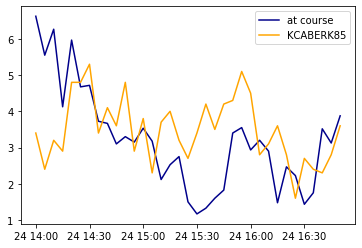

In [147]:
#Now do some plotting
plt.plot(merged_5min_df['course_spd'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_spd'], label='KCABERK85', c='orange')
plt.legend(loc='best')

In [148]:
#Let's do some statistics -- mean squared error
dif = np.subtract(merged_5min_df['course_spd'].values, merged_5min_df['PWS_spd'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
mse

2.2868492063492063

In [149]:
# Correlation
print(merged_5min_df['course_spd'].corr(merged_5min_df['PWS_spd']))
# Coeff of determination
print(r2_score(merged_5min_df['course_spd'].values, merged_5min_df['PWS_spd'].values))

0.20434139583273167
-0.18288508637754575


Mean squared error:6.7345
Pearson correlation coefficient:0.08231207243944771
Coefficient of determination
-1.7240963994663918


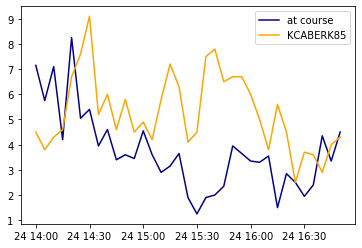

In [150]:
#Check gusts
plt.plot(merged_5min_df['course_gust'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_gust'], label='KCABERK85', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_gust'].values, merged_5min_df['PWS_gust'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_gust'].corr(merged_5min_df['PWS_gust']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_gust'].values, merged_5min_df['PWS_gust'].values))

Mean squared error:3690.9142857142856
Pearson correlation coefficient:nan
Coefficient of determination
0.0


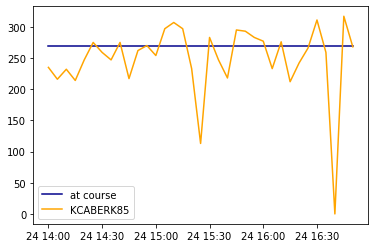

In [151]:
#Check direction
plt.plot(merged_5min_df['course_dir'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_dir'], label='KCABERK85', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_dir'].values, merged_5min_df['PWS_dir'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_dir'].corr(merged_5min_df['PWS_dir']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_dir'].values, merged_5min_df['PWS_dir'].values))

In [152]:
# Next station, KCAALBAN12
# To simulate this station, we need to take synthetic 16-second avg and max intervals, then average them over 5 minutes
# 1) Synthetic 16 sec max value from 1s / 60s data, assuming a Gaussian distributed wind speed
course_wx_df['gust_16'] = course_wx_df['Ave'] + st.norm.ppf(1.0 - 1/32) / st.norm.ppf (1.0 - 1/120) \
                          * (course_wx_df['Max'] - course_wx_df['Ave'])
# Add in wind direction
course_wx_df['Dir'] = 270
course_wx_df.head()

,Current,Min,Max,Ave,gust_16,Dir
dt,,,,,,
2019-07-24 14:03:41,10.5,0.0,15.0,6.1,13.025001,270
2019-07-24 14:04:41,7.2,4.1,11.4,7.4,10.512360,270
2019-07-24 14:05:41,7.0,3.6,11.1,6.9,10.167978,270
2019-07-24 14:06:41,8.2,2.4,8.7,6.4,8.189607,270
2019-07-24 14:07:41,4.3,2.3,7.7,4.3,6.945506,270


In [153]:
#2) Merge and resample at 5-min intervals -- use forward PWS reporting as explained earlier
merged_wx_df = pd.merge_asof(course_wx_df, wx_data_list[1], left_index=True, right_index=True, direction='forward')
# Now do the resampling via simple mean
merged_5min_df = merged_wx_df.resample('5T').mean()
# Clean up
merged_5min_df = merged_5min_df.drop(columns = ['Current','Min','Max','T','rh','precip'])
merged_5min_df.columns = ['course_spd','course_gust','course_dir','PWS_dir','PWS_spd','PWS_gust']
merged_5min_df.head()

,course_spd,course_gust,course_dir,PWS_dir,PWS_spd,PWS_gust
dt,,,,,,
2019-07-24 14:00:00,6.75,11.768681,270,217.0,9.50,12.85
2019-07-24 14:05:00,5.82,8.683371,270,216.0,9.84,12.90
2019-07-24 14:10:00,6.34,9.405675,270,212.2,10.20,13.62
2019-07-24 14:15:00,4.48,7.203315,270,208.2,9.98,13.76
2019-07-24 14:20:00,5.94,9.674832,270,211.8,8.82,12.12


Mean squared error:49.51566714285715
Pearson correlation coefficient:-0.3730139960360954
Coefficient of determination
-23.449670424372638


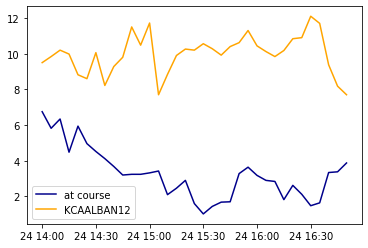

In [154]:
# Analyze speeds 
plt.plot(merged_5min_df['course_spd'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_spd'], label='KCAALBAN12', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_spd'].values, merged_5min_df['PWS_spd'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_spd'].corr(merged_5min_df['PWS_spd']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_spd'].values, merged_5min_df['PWS_spd'].values))

Mean squared error:67.045804416395
Pearson correlation coefficient:-0.1970384355288609
Coefficient of determination
-14.125877665815695


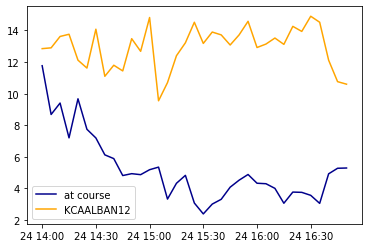

In [155]:
# Analyze gusts 
plt.plot(merged_5min_df['course_gust'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_gust'], label='KCAALBAN12', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_gust'].values, merged_5min_df['PWS_gust'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_gust'].corr(merged_5min_df['PWS_gust']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_gust'].values, merged_5min_df['PWS_gust'].values))

Mean squared error:4205.126000000001
Pearson correlation coefficient:nan
Coefficient of determination
0.0


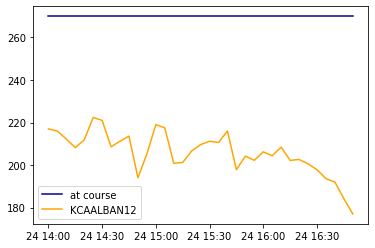

In [156]:
# Analyze direction 
plt.plot(merged_5min_df['course_dir'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_dir'], label='KCAALBAN12', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_dir'].values, merged_5min_df['PWS_dir'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_dir'].corr(merged_5min_df['PWS_dir']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_dir'].values, merged_5min_df['PWS_dir'].values))

In [157]:
# Next station, KCABERKE104
# This weather station is from the same manufacturer as KCAALBAN12, so we can use the same derived data
# from the course measurements, and just merge and re-sample with a different PWS source (wx_data_list[2])
# Merge and resample at 5-min intervals -- use forward PWS reporting as explained earlier
merged_wx_df = pd.merge_asof(course_wx_df, wx_data_list[2], left_index=True, right_index=True, direction='forward')
# Now do the resampling via simple mean
merged_5min_df = merged_wx_df.resample('5T').mean()
# Clean up
merged_5min_df = merged_5min_df.drop(columns = ['Current','Min','Max','T','rh','precip'])
merged_5min_df.columns = ['course_spd','course_gust','course_dir','PWS_dir','PWS_spd','PWS_gust']
merged_5min_df.head()

,course_spd,course_gust,course_dir,PWS_dir,PWS_spd,PWS_gust
dt,,,,,,
2019-07-24 14:00:00,6.75,11.768681,270,289.0,4.4,5.8
2019-07-24 14:05:00,5.82,8.683371,270,278.0,4.7,6.7
2019-07-24 14:10:00,6.34,9.405675,270,282.0,5.7,7.6
2019-07-24 14:15:00,4.48,7.203315,270,284.0,4.7,6.5
2019-07-24 14:20:00,5.94,9.674832,270,272.0,4.3,5.8


Mean squared error:2.5789528571428573
Pearson correlation coefficient:0.29806601624381984
Coefficient of determination
-0.27342619085024134


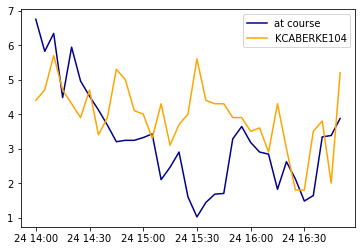

In [158]:
# Analyze speeds 
plt.plot(merged_5min_df['course_spd'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_spd'], label='KCABERKE104', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_spd'].values, merged_5min_df['PWS_spd'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_spd'].corr(merged_5min_df['PWS_spd']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_spd'].values, merged_5min_df['PWS_spd'].values))

Mean squared error:4.544257594599408
Pearson correlation coefficient:0.2626597412576672
Coefficient of determination
-0.025207841954928423


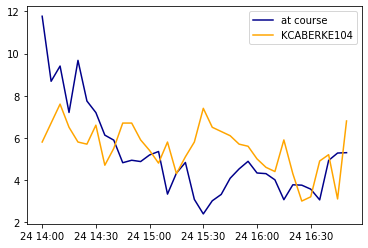

In [159]:
# Analyze gusts 
plt.plot(merged_5min_df['course_gust'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_gust'], label='KCABERKE104', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_gust'].values, merged_5min_df['PWS_gust'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_gust'].corr(merged_5min_df['PWS_gust']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_gust'].values, merged_5min_df['PWS_gust'].values))

Mean squared error:491.7142857142857
Pearson correlation coefficient:nan
Coefficient of determination
0.0


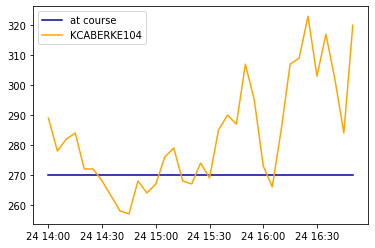

In [160]:
# Analyze direction 
plt.plot(merged_5min_df['course_dir'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_dir'], label='KCABERKE104', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_dir'].values, merged_5min_df['PWS_dir'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_dir'].corr(merged_5min_df['PWS_dir']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_dir'].values, merged_5min_df['PWS_dir'].values))

In [164]:
# For the last station, we need to deal with a 2.5s measuring interval and a 5-minute reporting period.
# Although the course anemometer is somewhat faster, because of inertia the 'max' is likely to be quite similar
# across 1s and 2.5s intervals, so we just need to merge and re-sample, with 'max' as max rather than mean, but
# we do not need to do any new computation on the course data
merged_wx_df = pd.merge_asof(course_wx_df, wx_data_list[3], left_index=True, right_index=True, direction='forward')
merged_wx_df = merged_wx_df.drop(columns = ['Current','Min','gust_16','T','rh','precip'])
# Now do the resampling via simple mean
merged_5min_df = merged_wx_df.resample('5T').agg({'Max':'max','Ave':'mean','Dir':'mean','w_dir':'mean',
                                                 'w_spd':'mean','w_gust':'max'})
# Clean up
merged_5min_df.columns = ['course_gust','course_spd','course_dir','PWS_dir','PWS_spd','PWS_gust']
merged_5min_df.head()

,course_gust,course_spd,course_dir,PWS_dir,PWS_spd,PWS_gust
dt,,,,,,
2019-07-24 14:00:00,15.0,6.75,270,248.0,3.0,9.0
2019-07-24 14:05:00,11.7,5.82,270,270.0,3.0,10.0
2019-07-24 14:10:00,12.3,6.34,270,248.0,3.0,9.0
2019-07-24 14:15:00,11.2,4.48,270,292.0,1.0,7.0
2019-07-24 14:20:00,13.9,5.94,270,270.0,2.0,9.0


Mean squared error:3.528638571428571
Pearson correlation coefficient:0.3007108088303654
Coefficient of determination
-0.7423586330615171


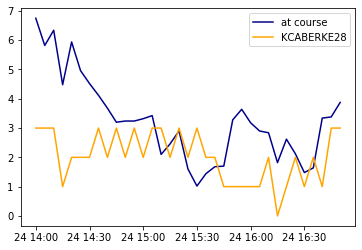

In [165]:
# Analyze speeds 
plt.plot(merged_5min_df['course_spd'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_spd'], label='KCABERKE28', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_spd'].values, merged_5min_df['PWS_spd'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_spd'].corr(merged_5min_df['PWS_spd']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_spd'].values, merged_5min_df['PWS_spd'].values))

Mean squared error:8.055428571428571
Pearson correlation coefficient:0.37521197960603725
Coefficient of determination
0.05161029899374314


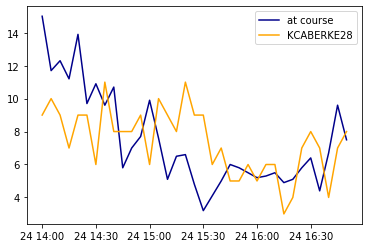

In [166]:
# Analyze gusts 
plt.plot(merged_5min_df['course_gust'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_gust'], label='KCABERKE28', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_gust'].values, merged_5min_df['PWS_gust'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_gust'].corr(merged_5min_df['PWS_gust']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_gust'].values, merged_5min_df['PWS_gust'].values))

Mean squared error:794.7428571428571
Pearson correlation coefficient:nan
Coefficient of determination
0.0


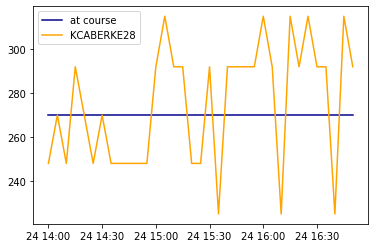

In [167]:
# Analyze direction 
plt.plot(merged_5min_df['course_dir'], label='at course', c='darkblue')
plt.plot(merged_5min_df['PWS_dir'], label='KCABERKE28', c='orange')
plt.legend(loc='best')
dif = np.subtract(merged_5min_df['course_dir'].values, merged_5min_df['PWS_dir'].values)
mse = np.sum(np.square(dif)) / len(merged_5min_df)
print('Mean squared error', end=':')
print(mse)
print('Pearson correlation coefficient', end=':')
print(merged_5min_df['course_dir'].corr(merged_5min_df['PWS_dir']))
print('Coefficient of determination')
print(r2_score(merged_5min_df['course_dir'].values, merged_5min_df['PWS_dir'].values))